In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import os
import base64
import json
import warnings
import folium

from PBA_Fetcher import PBA_Fetcher
from matplotlib.gridspec import GridSpec
from sqlalchemy import create_engine
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import fcluster
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.base import clone
from scipy.spatial.distance import euclidean, cityblock
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
fetcher = PBA_Fetcher()

In [13]:
fetcher.get_avg_player()

,year,conference,player_name,team_name,pos,j_number,height,weight,GP,MIN,...,APG,STL,BLK,oREB,dREB,REB,PF,TOV,+/-,PTS
0,2017,GOV,L. Henton,ALA,F,0.0,78.0,206.0,11,41.81,...,2.36,1.64,2.09,3.09,8.64,11.73,1.82,3.55,-4.45,28.09
1,2017,GOV,C. Abueva,ALA,F,0.0,73.0,209.0,8,28.19,...,2.25,1.25,1.00,3.63,7.00,10.63,2.38,3.00,-0.50,15.00
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,3.64,0.91,0.18,0.36,2.73,3.09,2.27,1.55,-1.00,10.27
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,3.10,0.90,0.20,1.40,2.40,3.80,2.50,2.30,-7.90,9.30
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,0.25,0.38,0.25,1.13,3.63,4.75,1.63,0.75,-3.38,8.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0.00,0.00,0.00,3.00,2.00,5.00,2.00,2.00,-8.00,3.00
1418,2020,PH,P. Zamar,SMB,G,0.0,70.0,215.0,1,4.52,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,3.00
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,184.0,1,5.57,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-6.00,0.00
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00,0.00


In [14]:
fetcher.get_avg_total_player()

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,APG_total,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total
0,2017,GOV,L. Henton,ALA,F,0.0,78.0,206.0,11,41.81,...,26,18,23,34,95,129,20,39,-49,309
1,2017,GOV,C. Abueva,ALA,F,0.0,73.0,209.0,8,28.19,...,18,10,8,29,56,85,19,24,-4,120
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,40,10,2,4,30,34,25,17,-11,113
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,31,9,2,14,24,38,25,23,-79,93
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,2,3,2,9,29,38,13,6,-27,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0,0,0,3,2,5,2,2,-8,3
1418,2020,PH,P. Zamar,SMB,G,0.0,70.0,215.0,1,4.52,...,0,0,0,0,0,0,0,0,-4,3
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,184.0,1,5.57,...,0,1,0,0,0,0,0,1,-6,0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0,0,0,0,0,0,0,0,-3,0


In [15]:
fetcher.get_all()

,year,conference,player_name,team_name,pos,j_number,height,weight,ply_GP_avg,ply_MIN_avg,...,tm_TO_total,tm_PTO_total,tm_PF_total,tm_FBm_total,tm_FBa_total,tm_FBm%_total,tm_bPTS_total,tm_PTS_total,tm_W_total,tm_L_total
0,2017,GOV,L. Henton,ALA,F,0.0,78.0,206.0,11,41.81,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
1,2017,GOV,C. Abueva,ALA,F,0.0,73.0,209.0,8,28.19,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,15.64,17.64,22.27,7.18,8.18,11.91,36.73,94.0,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1418,2020,PH,P. Zamar,SMB,G,0.0,70.0,215.0,1,4.52,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,184.0,1,5.57,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,19.00,21.00,26.00,6.00,6.00,13.00,16.00,94.0,1,0


## Representative Clustering by avg + total

In [16]:
df_avgtot = fetcher.get_avg_total_player()
df_avgtot

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,APG_total,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total
0,2017,GOV,L. Henton,ALA,F,0.0,78.0,206.0,11,41.81,...,26,18,23,34,95,129,20,39,-49,309
1,2017,GOV,C. Abueva,ALA,F,0.0,73.0,209.0,8,28.19,...,18,10,8,29,56,85,19,24,-4,120
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,40,10,2,4,30,34,25,17,-11,113
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,31,9,2,14,24,38,25,23,-79,93
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,2,3,2,9,29,38,13,6,-27,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0,0,0,3,2,5,2,2,-8,3
1418,2020,PH,P. Zamar,SMB,G,0.0,70.0,215.0,1,4.52,...,0,0,0,0,0,0,0,0,-4,3
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,184.0,1,5.57,...,0,1,0,0,0,0,0,1,-6,0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0,0,0,0,0,0,0,0,-3,0


In [17]:
df_fin00 = df_avgtot[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]
#                       'MIN_total', 'FGm_total', 'FGa_total', 'FG%_total', 'GP_total',
#                       '3Pm_total', '3Pa_total', '3P%_total', 'FTm_total',
#                       'FTa_total', 'FT%_total', 'APG_total', 'STL_total',
#                       'BLK_total', 'oREB_total', 'dREB_total', 'REB_total',
#                       'PF_total', 'TOV_total', '+/-_total', 'PTS_total']]
df_fin01 = df_fin00.drop(['year', 'pos'], axis=1)
df_fin01

,height,weight,GP_avg,MIN_avg,FGm_avg,FGa_avg,FG%_avg,3Pm_avg,3Pa_avg,3P%_avg,...,APG_avg,STL_avg,BLK_avg,oREB_avg,dREB_avg,REB_avg,PF_avg,TOV_avg,+/-_avg,PTS_avg
0,78.0,206.0,11,41.81,10.18,24.09,0.42,2.91,8.82,0.33,...,2.36,1.64,2.09,3.09,8.64,11.73,1.82,3.55,-4.45,28.09
1,73.0,209.0,8,28.19,5.50,14.25,0.39,0.38,2.38,0.16,...,2.25,1.25,1.00,3.63,7.00,10.63,2.38,3.00,-0.50,15.00
2,70.0,175.0,11,23.81,3.82,8.00,0.48,1.27,3.73,0.34,...,3.64,0.91,0.18,0.36,2.73,3.09,2.27,1.55,-1.00,10.27
3,74.0,175.0,10,23.40,3.60,9.30,0.39,0.60,1.70,0.35,...,3.10,0.90,0.20,1.40,2.40,3.80,2.50,2.30,-7.90,9.30
4,76.0,227.0,8,16.89,3.38,8.50,0.40,0.00,0.00,0.00,...,0.25,0.38,0.25,1.13,3.63,4.75,1.63,0.75,-3.38,8.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,78.0,185.0,1,11.52,1.00,2.00,0.50,0.00,0.00,0.00,...,0.00,0.00,0.00,3.00,2.00,5.00,2.00,2.00,-8.00,3.00
1418,70.0,215.0,1,4.52,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,3.00
1419,76.0,184.0,1,5.57,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-6.00,0.00
1420,74.0,215.0,1,9.65,0.00,1.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00,0.00


### KMeans

In [18]:
def plot_clusters(X, ys):
    """Plot clusters given the design matrix and cluster labels"""
    k_max = len(ys) + 1
    k_mid = k_max//2 + 2
    fig, ax = plt.subplots(2, k_max//2, dpi=150, sharex=True, sharey=True,
                           figsize=(7, 4), subplot_kw=dict(aspect='equal'),
                           gridspec_kw=dict(wspace=0.01))
    for k, y in zip(range(2, k_max+1), ys):
        if k < k_mid:
            ax[0][k % k_mid-2].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[0][k % k_mid-2].set_title('$k=%d$' % k)
        else:
            ax[1][k % k_mid].scatter(*zip(*X), c=y, s=1, alpha=0.8)
            ax[1][k % k_mid].set_title('$k=%d$' % k)
    return ax

def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point

    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    # YOUR CODE HERE
    n_i = np.bincount(y.astype(int))
    return sum(dist(x_i, centroids[y_i])**2 / (2*n_i[y_i])
               for x_i, y_i in zip(X, y.astype(int)))

def gap_statistic(X, y, centroids, dist, b, clusterer):
    """Compute the gap statistic

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations

    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for i in range(b):
        cluster = clone(clusterer)
        cluster.set_params(n_clusters=len(centroids))
        xi = rng.uniform(xmin, xmax, size=X.shape)
        yi = cluster.fit_predict(xi)
        res.append(np.log(pooled_within_ssd(
            xi, yi, cluster.cluster_centers_, dist)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, dist))),
            np.std(res - np.log(pooled_within_ssd(X, y, centroids, dist)))
            )


def gap_statistic_kmedians(X, y, centroids, b):
    """Compute the gap statistic for a k-medians clusterer
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for _ in range(b):
        xi = np.random.uniform(xmin, xmax, size=X.shape)
        kmd = kmedians(xi, xi[:len(centroids),:], ccore=False)
        kmd.process()
        clusters = kmd.get_clusters()
        yi = np.zeros(len(X))
        for cluster, point in enumerate(clusters):
            yi[point] = cluster
        res.append(np.log(pooled_within_ssd(
            xi, yi, kmd.get_medians(), cityblock)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, cityblock))),
            np.std(res -
                   np.log(pooled_within_ssd(X, y, centroids, cityblock))))


def gap_statistic_kmedoids(X, y, centroids, b):
    """Compute the gap statistic for a k-medoids clusterer

    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    b : int
        Number of realizations for the reference distribution

    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    np.random.seed(0)
    xmin = X.min(axis=0)
    xmax = X.max(axis=0)
    res = []
    for i in range(b):
        xi = np.random.uniform(xmin, xmax, size=X.shape)
        clusterer_k = kmedoids(xi, np.arange(len(centroids)),
                               ccore=False)
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        yi = np.zeros(len(xi))
        for cluster, points in enumerate(clusters):
            yi[points] = cluster
        res.append(np.log(pooled_within_ssd(
            xi, yi, xi[clusterer_k.get_medoids()], euclidean)))
    return (np.mean(res -
                    np.log(pooled_within_ssd(X, y, centroids, euclidean))),
            np.std(res -
                   np.log(pooled_within_ssd(X, y, centroids, euclidean))))


def cluster_range(X, clusterer, k_start, k_stop):
    """
    Return a dictionary of the cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    clusterer : object
         clustering object
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = clone(clusterer)
        # YOUR CODE HERE
        clusterer_k.set_params(n_clusters=k)
        y = clusterer_k.fit_predict(X)
        ys.append(y)
        inertias.append(clusterer_k.inertia_)
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic(X, y, clusterer_k.cluster_centers_,
                           euclidean, 5,
                           clone(clusterer).set_params(n_clusters=k))
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res


def cluster_range_kmedians(X, k_start, k_stop):
    """
    Return a dictionary of the kmedians cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedians(X, X[:k,:], ccore=False)
        # YOUR CODE HERE
        clusterer_k.process()
        clusters = clusterer_k.get_clusters()
        kmedian = clusterer_k.get_medians()
        y = np.zeros(len(X))
        for cluster, point in enumerate(clusters):
            y[point] = cluster
        ys.append(y)
        inertias.append(pooled_within_ssd(X, y, kmedian, euclidean))
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic_kmedians(X, y, kmedian, 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res


def cluster_range_kmedoids(X, k_start, k_stop):
    """
    Return a dictionary of the kmedoids cluster labels, internal validation
    values and, if actual labels is given, external validation values,
    for every  𝑘.

    Parameters
    ----------
    X : matrix
        design matrix
    k_start : int
        start of cluster
    k_stop : int
        stop of cluster

    Returns
    -------
    cluster_range : dictionary
        Cluster range
    """
    ys = []
    inertias = []
    chs = []
    scs = []
    gss = []
    gssds = []
    ps = []
    amis = []
    ars = []
    for k in range(k_start, k_stop+1):
        clusterer_k = kmedoids(X, np.arange(k), ccore=False)
        # YOUR CODE HERE
        clusterer_k.process()
        centers = clusterer_k.get_medoids()
        clusters = clusterer_k.get_clusters()
        y = np.zeros(len(X))
        for cluster, points in enumerate(clusters):
            y[points] = cluster
        ys.append(y)
        inertias.append(sum(euclidean(u, X[centers][v]) ** 2
                            for u, v in zip(X, y.astype(int))))
        chs.append(calinski_harabasz_score(X, y))
        scs.append(silhouette_score(X, y))
        gs = gap_statistic_kmedoids(X, y, X[centers], 5)
        gss.append(gs[0])
        gssds.append(gs[1])
    # YOUR CODE HERE
    res = dict(
        ys=ys,
        inertias=inertias,
        chs=chs,
        scs=scs,
        gss=gss,
        gssds=gssds
    )
    return res

def plot_internal(inertias, chs, scs, gss, gssds):
    """Plot internal validation values"""
    fig, ax = plt.subplots()
    ks = np.arange(2, len(inertias)+2)
    ax.plot(ks, inertias, '-o', label='SSE')
    ax.plot(ks, chs, '-ro', label='CH')
    ax.set_xlabel('$k$')
    ax.set_ylabel('SSE/CH')
    lines, labels = ax.get_legend_handles_labels()
    ax2 = ax.twinx()
    ax2.errorbar(ks, gss, gssds, fmt='-go', label='Gap statistic')
    ax2.plot(ks, scs, '-ko', label='Silhouette coefficient')
    ax2.set_ylabel('Gap statistic/Silhouette')
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines+lines2, labels+labels2)
    return ax

standard_scaler = StandardScaler()

In [19]:
df_fin01_sc = standard_scaler.fit_transform(df_fin01)
df_fin01_re = PCA(n_components=2, random_state=0).fit_transform(df_fin01_sc)

In [20]:
kmeans_allave = cluster_range(df_fin01_re, KMeans(random_state=0), 2, 9)

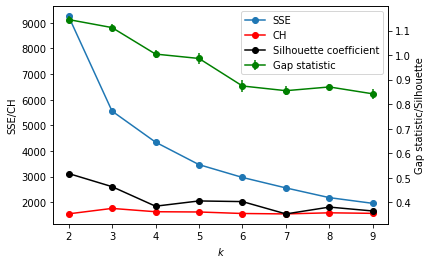

In [21]:
plot_internal(kmeans_allave['inertias'], kmeans_allave['chs'],
              kmeans_allave['scs'],  kmeans_allave['gss'],
              kmeans_allave['gssds']);

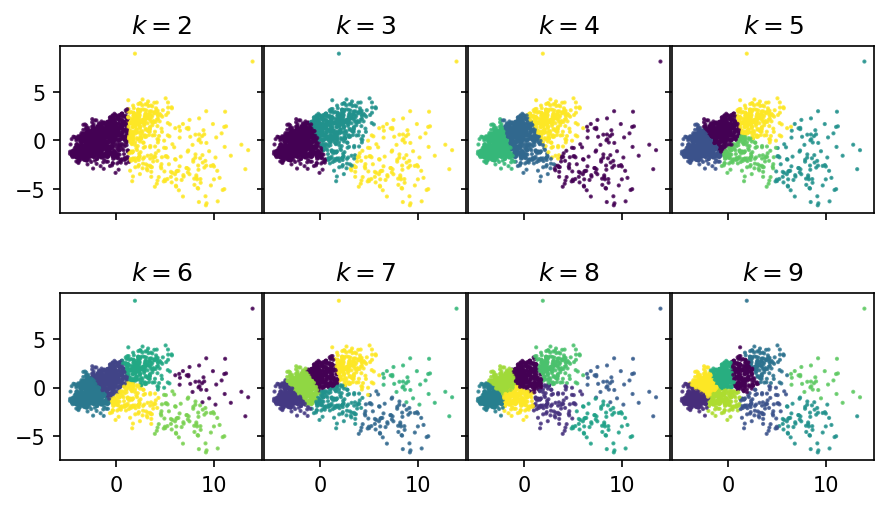

In [22]:
plot_clusters(df_fin01_re, kmeans_allave['ys']);

In [23]:
kmeans_3 = KMeans(n_clusters=3)
y_predict_new3 = kmeans_3.fit_predict(df_fin01_re)
y_predict_new3

array([1, 1, 2, ..., 0, 0, 0])

In [24]:
df_fin01['cluster'] = y_predict_new3
df_fin01

,height,weight,GP_avg,MIN_avg,FGm_avg,FGa_avg,FG%_avg,3Pm_avg,3Pa_avg,3P%_avg,...,STL_avg,BLK_avg,oREB_avg,dREB_avg,REB_avg,PF_avg,TOV_avg,+/-_avg,PTS_avg,cluster
0,78.0,206.0,11,41.81,10.18,24.09,0.42,2.91,8.82,0.33,...,1.64,2.09,3.09,8.64,11.73,1.82,3.55,-4.45,28.09,1
1,73.0,209.0,8,28.19,5.50,14.25,0.39,0.38,2.38,0.16,...,1.25,1.00,3.63,7.00,10.63,2.38,3.00,-0.50,15.00,1
2,70.0,175.0,11,23.81,3.82,8.00,0.48,1.27,3.73,0.34,...,0.91,0.18,0.36,2.73,3.09,2.27,1.55,-1.00,10.27,2
3,74.0,175.0,10,23.40,3.60,9.30,0.39,0.60,1.70,0.35,...,0.90,0.20,1.40,2.40,3.80,2.50,2.30,-7.90,9.30,2
4,76.0,227.0,8,16.89,3.38,8.50,0.40,0.00,0.00,0.00,...,0.38,0.25,1.13,3.63,4.75,1.63,0.75,-3.38,8.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,78.0,185.0,1,11.52,1.00,2.00,0.50,0.00,0.00,0.00,...,0.00,0.00,3.00,2.00,5.00,2.00,2.00,-8.00,3.00,0
1418,70.0,215.0,1,4.52,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.00,3.00,0
1419,76.0,184.0,1,5.57,0.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,-6.00,0.00,0
1420,74.0,215.0,1,9.65,0.00,1.00,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00,0.00,0


In [25]:
df_cluster1 = df_fin01.groupby('cluster').mean()
df_cluster1[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg']]

,PTS_avg,3Pm_avg,REB_avg,APG_avg,BLK_avg
cluster,,,,,
0,2.952579,0.274311,1.882035,0.674994,0.165588
1,22.403139,1.013650,12.667737,3.370657,1.386350
2,10.593745,1.244069,4.372672,2.671802,0.291437


In [26]:
df_avgtot['cluster'] = y_predict_new3
df_avgtot

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
0,2017,GOV,L. Henton,ALA,F,0.0,78.0,206.0,11,41.81,...,18,23,34,95,129,20,39,-49,309,1
1,2017,GOV,C. Abueva,ALA,F,0.0,73.0,209.0,8,28.19,...,10,8,29,56,85,19,24,-4,120,1
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,10,2,4,30,34,25,17,-11,113,2
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,9,2,14,24,38,25,23,-79,93,2
4,2017,GOV,V. Manuel,ALA,F,0.0,76.0,227.0,8,16.89,...,3,2,9,29,38,13,6,-27,67,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,0.0,78.0,185.0,1,11.52,...,0,0,3,2,5,2,2,-8,3,0
1418,2020,PH,P. Zamar,SMB,G,0.0,70.0,215.0,1,4.52,...,0,0,0,0,0,0,0,-4,3,0
1419,2020,PH,R. Gamalinda,SMB,G,0.0,76.0,184.0,1,5.57,...,1,0,0,0,0,0,1,-6,0,0
1420,2020,PH,V. Pessumal,SMB,G,0.0,74.0,215.0,1,9.65,...,0,0,0,0,0,0,0,-3,0,0


In [27]:
df_gov = df_avgtot[(df_avgtot['conference'] == 'PH')]
df_per_team = df_gov.groupby(['team_name', 'cluster']).count()
df_per_team

year  conference  player_name  pos  j_number  height  \
team_name cluster                                                         
ALA       0          16          16           16   16        16      16   
          1           1           1            1    1         1       1   
          2          14          14           14   14        14      14   
BWE       0          21          21           21   21        21      21   
          1           1           1            1    1         1       1   
          2           9           9            9    9         9       9   
COL       0          20          20           20   20        20      20   
          2          14          14           14   14        14      14   
GIN       0          19          19           19   19        19      19   
          1           4           4            4    4         4       4   
          2           8           8            8    8         8       8   
GLO       0          14          14           14   14        14      14   
          1           2           2            2    2         2       2   
          2          11          11           11   11        11      11   
MAG       0          21          21           21   21        21      21   
          1           3           3            3    3         3       3   
          2          15          15           15   15        15      15   
MER       0          16          16           16   16        16      16   
          2          14          14           14   14        14      14   
NLX       0          21          21           21   21        21      21   
          1           1           1            1    1         1       1   
          2          13          13           13   13        13      13   
PHX       0          19          19           19   19        19      19   
          1           1           1            1    1         1       1   
          2          12          12           12   12        12      12   
ROS       0          16          16           16   16        16      16   
          2          16          16           16   16        16      16   
SMB       0          24          24           24   24        24      24   
          1           4           4            4    4         4       4   
          2          15          15           15   15        15      15   
TNT       0          17          17           17   17        17      17   
          2          17          17           17   17        17      17   

                   weight  GP_avg  MIN_avg  FGm_avg  ...  APG_total  \
team_name cluster                                    ...              
ALA       0            16      16       16       16  ...         16   
          1             1       1        1        1  ...          1   
          2            14      14       14       14  ...         14   
BWE       0            21      21       21       21  ...         21   
          1             1       1        1        1  ...          1   
          2             9       9        9        9  ...          9   
COL       0            20      20       20       20  ...         20   
          2            14      14       14       14  ...         14   
GIN       0            19      19       19       19  ...         19   
          1             4       4        4        4  ...          4   
          2             8       8        8        8  ...          8   
GLO       0            14      14       14       14  ...         14   
          1             2       2        2        2  ...          2   
          2            11      11       11       11  ...         11   
MAG       0            21      21       21       21  ...         21   
          1             3       3        3        3  ...          3   
          2            15      15       15       15  ...         15   
MER       0            16      16       16       16  ...         16   
          2            14      14       14      

In [28]:
df_godz_ph = df_avgtot[(df_avgtot['conference'] == 'PH') & (df_avgtot['cluster'] == 1)]
df_godz_ph

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
630,2018,PH,C. Abueva,ALA,F,0.0,73.0,209.0,9,0.32,...,15,12,28,65,93,31,33,36,124,1
646,2018,PH,J. Erram,BWE,C,0.0,79.0,200.0,11,0.00,...,9,33,66,86,152,35,30,4,156,1
678,2018,PH,J. Aguilar,GIN,F,25.0,81.0,235.0,11,1.16,...,6,15,25,64,89,33,36,34,212,1
679,2018,PH,G. Slaughter,GIN,C,0.0,84.0,258.0,7,0.00,...,1,12,27,46,73,10,17,55,117,1
789,2018,PH,J. Fajardo,SMB,C,0.0,82.0,225.0,10,3.68,...,6,21,50,83,133,17,34,59,228,1
1263,2019,PH,J. Aguilar,GIN,F,25.0,81.0,235.0,11,28.38,...,11,15,26,57,83,18,34,24,182,1
1264,2019,PH,G. Slaughter,GIN,C,0.0,84.0,258.0,11,29.76,...,5,10,27,71,98,18,27,41,170,1
1278,2019,PH,I. Sangalang,MAG,F,0.0,79.0,175.0,11,33.56,...,10,18,39,67,106,32,34,62,173,1
1308,2019,PH,J. Erram,NLX,C,0.0,79.0,200.0,12,28.37,...,9,32,35,85,120,38,35,56,172,1
1326,2019,PH,S. Anthony,GLO,F,10.0,76.0,202.0,11,34.53,...,30,2,25,73,98,44,38,69,228,1


In [29]:
df_godz_com = df_avgtot[(df_avgtot['conference'] == 'GOV') & (df_avgtot['cluster'] == 2)]
df_godz_com

,year,conference,player_name,team_name,pos,j_number,height,weight,GP_avg,MIN_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
2,2017,GOV,J. Casio,ALA,G,0.0,70.0,175.0,11,23.81,...,10,2,4,30,34,25,17,-11,113,2
3,2017,GOV,C. Banchero,ALA,G,22.0,74.0,175.0,10,23.40,...,9,2,14,24,38,25,23,-79,93,2
6,2017,GOV,S. Enciso,ALA,G,0.0,71.0,235.0,11,18.97,...,4,1,1,13,14,14,6,-14,80,2
19,2017,GOV,T. Simpson,BWE,F,0.0,79.0,230.0,3,25.13,...,3,0,3,14,17,2,3,-32,49,2
20,2017,GOV,M. Digregorio,BWE,G,0.0,73.0,220.0,11,32.99,...,6,1,6,30,36,26,29,-59,163,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1198,2019,GOV,R. Pogoy,TNT,F,0.0,74.0,210.0,11,41.62,...,20,2,16,42,58,33,16,82,223,2
1199,2019,GOV,J. Rosario,TNT,F,0.0,79.0,180.0,11,32.58,...,2,1,15,44,59,39,26,73,190,2
1200,2019,GOV,W. Castro,TNT,G,0.0,70.0,170.0,9,32.01,...,10,1,9,35,44,21,28,70,128,2
1201,2019,GOV,B. Parks,TNT,G,0.0,76.0,200.0,3,38.09,...,1,1,2,14,16,14,7,7,42,2


## PHILIPPINE CUP CLUSTERING

In [30]:
df_ph_c1 = df_avgtot[(df_avgtot['conference'] == 'PH')]
df_ph_c1 = df_ph_c1.drop('j_number', axis=1)
df_ph_c = df_ph_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_ph_c = df_ph_c.drop(['year', 'pos'], axis=1)
df_ph_sc = standard_scaler.fit_transform(df_ph_c)
df_ph_re = PCA(n_components=2, random_state=0).fit_transform(df_ph_sc)
df_ph_c1

,year,conference,player_name,team_name,pos,height,weight,GP_avg,MIN_avg,FGm_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
629,2018,PH,V. Manuel,ALA,F,76.0,227.0,11,0.45,5.91,...,13,4,17,32,49,20,16,13,153,2
630,2018,PH,C. Abueva,ALA,F,73.0,209.0,9,0.32,5.33,...,15,12,28,65,93,31,33,36,124,1
631,2018,PH,J. Teng,ALA,G,74.0,155.0,10,0.00,5.00,...,10,1,11,32,43,20,19,-21,131,2
632,2018,PH,J. Casio,ALA,G,70.0,175.0,11,0.45,3.64,...,9,2,8,37,45,26,15,60,130,2
633,2018,PH,C. Banchero,ALA,G,74.0,175.0,9,0.24,4.33,...,15,0,11,24,35,25,16,50,104,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,2020,PH,R. Escoto,SMB,C,78.0,185.0,1,11.52,1.00,...,0,0,3,2,5,2,2,-8,3,0
1418,2020,PH,P. Zamar,SMB,G,70.0,215.0,1,4.52,1.00,...,0,0,0,0,0,0,0,-4,3,0
1419,2020,PH,R. Gamalinda,SMB,G,76.0,184.0,1,5.57,0.00,...,1,0,0,0,0,0,1,-6,0,0
1420,2020,PH,V. Pessumal,SMB,G,74.0,215.0,1,9.65,0.00,...,0,0,0,0,0,0,0,-3,0,0


In [31]:
kmeans_all_ph = cluster_range(df_ph_re, KMeans(random_state=0), 2, 9)

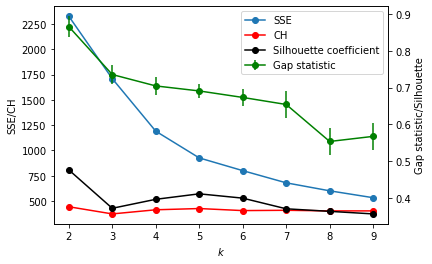

In [32]:
plot_internal(kmeans_all_ph['inertias'], kmeans_all_ph['chs'],
              kmeans_all_ph['scs'],  kmeans_all_ph['gss'],
              kmeans_all_ph['gssds']);

In [33]:
kmeans_ph = KMeans(n_clusters=4, random_state=1337)
y_predict_ph3 = kmeans_ph.fit_predict(df_ph_re)


In [34]:
df_ph_c1['cluster'] = y_predict_ph3
df_ph_c1 = df_ph_c1.replace({'cluster': 2}, "Role Players")
df_ph_c1 = df_ph_c1.replace({'cluster': 1}, "Bench Warmers")
df_ph_c1 = df_ph_c1.replace({'cluster': 3}, "Big Men")
df_ph_c1 = df_ph_c1.replace({'cluster': 0}, "Starters")
df_ph_c10 = df_ph_c1.groupby('cluster').mean()

df_ph_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height',
           'FG%_avg', '3P%_avg']]

,PTS_avg,3Pm_avg,REB_avg,APG_avg,BLK_avg,height,FG%_avg,3P%_avg
cluster,,,,,,,,
Bench Warmers,2.218058,0.224460,1.403022,0.501007,0.113741,74.474820,0.348777,0.181439
Big Men,13.960294,0.332647,8.915588,2.108529,1.129118,78.176471,0.484412,0.253529
Role Players,6.535629,0.628543,3.786755,1.395894,0.257483,74.933775,0.414437,0.263377
Starters,13.536933,1.818000,5.206267,3.607200,0.334533,73.280000,0.415333,0.349867


In [45]:
df_10000 = df_ph_c1[df_ph_c1['player_name'].apply(lambda x: 'Pringle' in x)]
df_10000[['year', 'PTS_avg', "APG_avg", 'REB_avg', 'FG%_avg', 'MIN_avg']]

,year,PTS_avg,APG_avg,REB_avg,FG%_avg,MIN_avg
741,2018,20.18,4.64,7.73,0.42,0.45
1327,2019,20.50,4.60,6.10,0.47,36.83


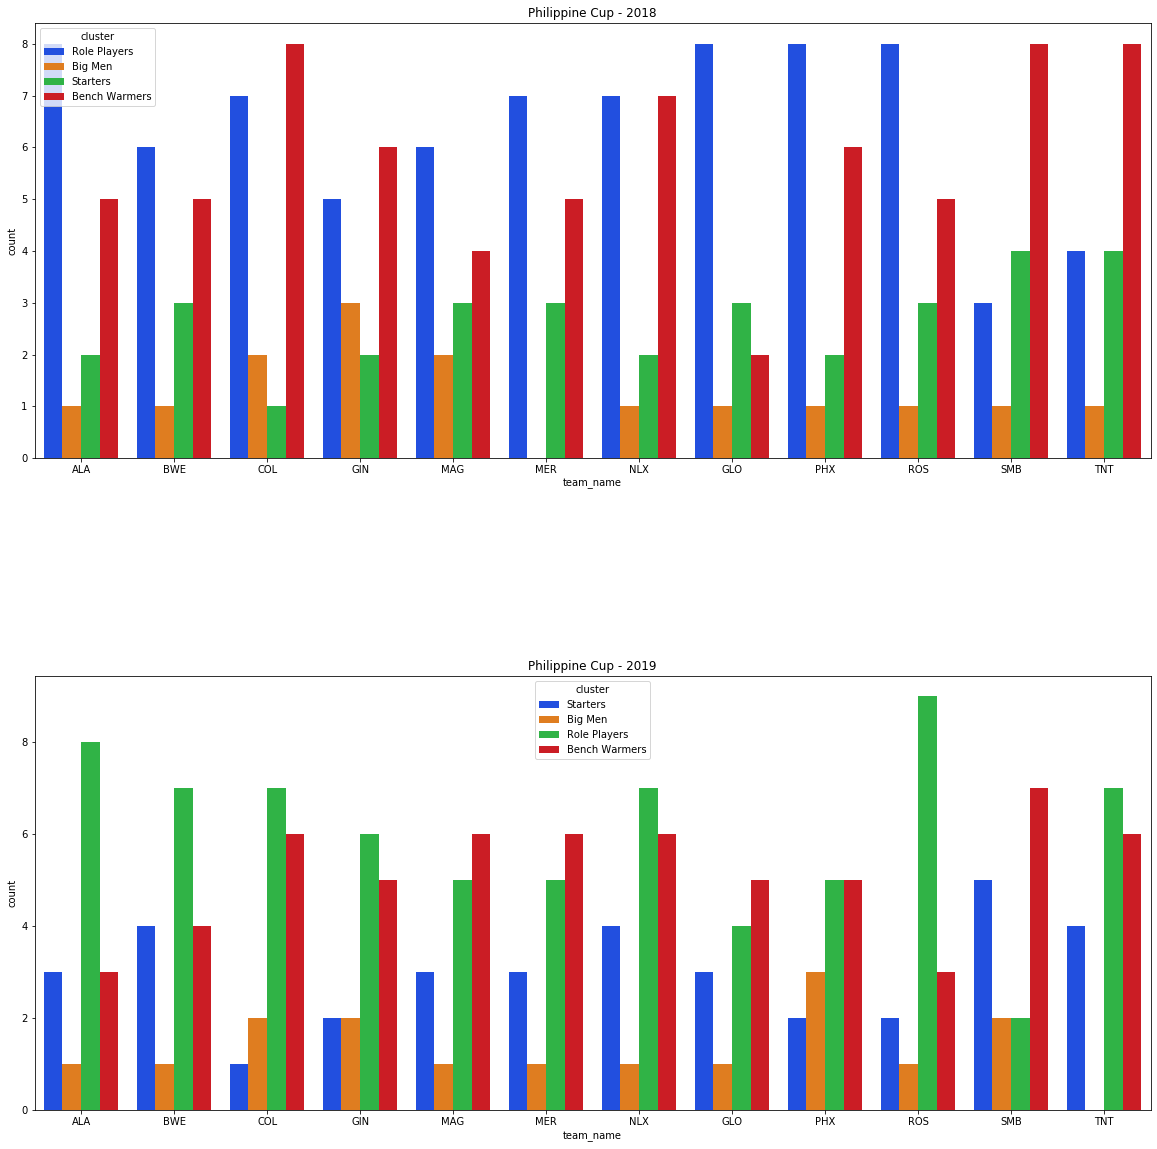

In [43]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)

years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_ph_c1[df_ph_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title('Philippine Cup - ' + years[x])


## COMMISSIONER'S CUP CLUSTERING

In [44]:
df_com_c1 = df_avgtot[(df_avgtot['conference'] == 'COM')]
df_com_c1 = df_com_c1.drop('j_number', axis=1)
df_com_c = df_com_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_com_c = df_com_c.drop(['year', 'pos'], axis=1)
df_com_sc = standard_scaler.fit_transform(df_com_c)
df_com_re = PCA(n_components=2, random_state=0).fit_transform(df_com_sc)
df_com_c1

,year,conference,player_name,team_name,pos,height,weight,GP_avg,MIN_avg,FGm_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
217,2018,COM,V. Manuel,ALA,F,76.0,227.0,11,21.96,10.36,...,9,7,13,57,70,22,23,68,266,0
218,2018,COM,A. Campbell,ALA,F,80.0,265.0,10,31.69,8.30,...,12,15,29,119,148,36,30,13,226,1
219,2018,COM,D. Simpson,ALA,C,79.0,240.0,1,31.68,6.00,...,0,4,4,15,19,3,4,18,18,1
220,2018,COM,C. Abueva,ALA,F,73.0,209.0,5,19.90,3.40,...,11,6,15,32,47,11,17,43,52,1
221,2018,COM,C. Banchero,ALA,G,74.0,175.0,11,27.34,3.91,...,12,0,10,28,38,27,23,9,108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,2019,COM,D. Semerad,TNT,F,77.0,226.0,10,5.71,0.30,...,1,1,9,8,17,16,8,2,8,2
1023,2019,COM,J. Casiño,TNT,G,70.0,175.0,9,3.34,0.11,...,0,0,1,2,3,4,1,-27,3,2
1024,2019,COM,F. Golla,TNT,F,74.0,290.0,6,1.76,0.00,...,0,0,1,0,1,1,1,-19,0,2
1025,2019,COM,H. Carey,TNT,F,75.0,210.0,2,2.81,0.00,...,0,0,0,1,1,0,0,3,0,2


In [45]:
kmeans_all_com = cluster_range(df_com_re, KMeans(random_state=0), 2, 9)

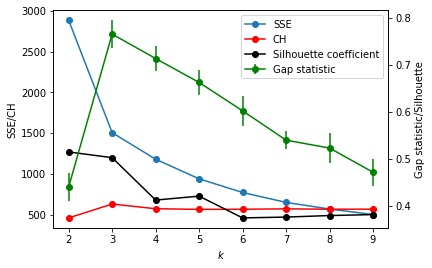

In [46]:
plot_internal(kmeans_all_com['inertias'], kmeans_all_com['chs'],
              kmeans_all_com['scs'],  kmeans_all_com['gss'],
              kmeans_all_com['gssds'])

In [47]:
kmeans_com = KMeans(n_clusters=4, random_state=0)
y_predict_com3 = kmeans_com.fit_predict(df_com_re)

In [52]:
df_com_c1['cluster'] = y_predict_com3
df_com_c1 = df_com_c1.replace({'cluster': 3}, "Role Players")
df_com_c1 = df_com_c1.replace({'cluster': 1}, "Imports + Big Men")
df_com_c1 = df_com_c1.replace({'cluster': 0}, "Bench Warmers")
df_com_c1 = df_com_c1.replace({'cluster': 2}, "Starters")
df_com_c10 = df_com_c1.groupby('cluster').mean()
df_com_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height']]

,PTS_avg,3Pm_avg,REB_avg,APG_avg,BLK_avg,height
cluster,,,,,,
Bench Warmers,2.294840,0.171809,1.534734,0.524628,0.138351,75.053191
Imports + Big Men,22.879762,0.798333,14.420476,3.079762,1.733810,80.500000
Role Players,7.060984,0.816311,3.342541,1.843525,0.238689,74.688525
Starters,14.051471,1.703676,4.978382,3.993676,0.286324,73.558824


In [63]:
df_commi_imp = df_com_c1[df_com_c1['cluster'] == "Role Players"]
df_commi_imp[['player_name', 'MIN_avg', 'PTS_avg', 'REB_avg']].sort_values(by='PTS_avg', ascending=False)[:20]

,player_name,MIN_avg,PTS_avg,REB_avg
825,V. Manuel,21.58,13.50,4.63
876,J. Aguilar,26.90,13.36,4.91
293,I. Sangalang,23.30,12.50,6.83
403,C. Standhardinger,24.32,12.20,7.20
878,A. Dela Cruz,26.05,12.00,5.00
895,J. Fields,30.18,12.00,6.00
326,J. Quinahan,24.66,12.00,4.36
365,J. Perkins,20.95,11.82,6.00
418,R. Pogoy,21.29,11.18,4.09
258,E. Camson,20.04,11.10,4.40


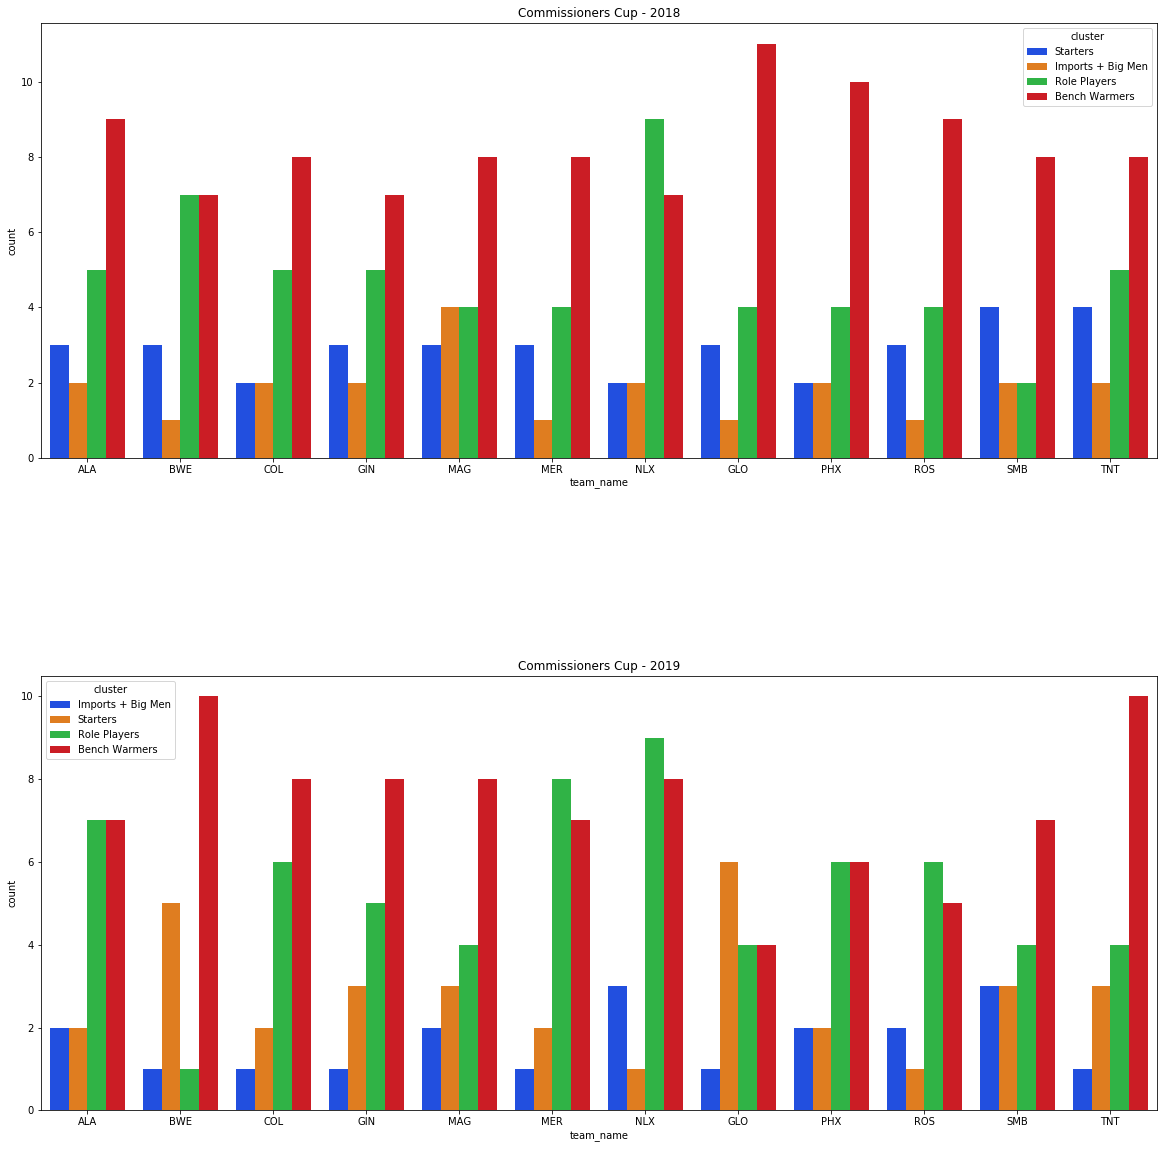

In [53]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)
years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_com_c1[df_com_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title('Commissioners Cup - ' + years[x])

## GOVERNOR'S CUP CLUSTERING

In [80]:
df_gov_c1 = df_avgtot[(df_avgtot['conference'] == 'GOV')]
df_gov_c1 = df_gov_c1.drop('j_number', axis=1)
df_gov_c = df_gov_c1[['year','pos', 'height', 'weight', 'GP_avg', 'MIN_avg',
                      'FGm_avg', 'FGa_avg', 'FG%_avg', '3Pm_avg', '3Pa_avg',
                      '3P%_avg', 'FTm_avg', 'FTa_avg', 'FT%_avg', 'APG_avg',
                      'STL_avg', 'BLK_avg', 'oREB_avg', 'dREB_avg', 'REB_avg',
                      'PF_avg', 'TOV_avg', '+/-_avg', 'PTS_avg']]

df_gov_c = df_gov_c.drop(['year', 'pos'], axis=1)
df_gov_sc = standard_scaler.fit_transform(df_gov_c)
df_gov_re = PCA(n_components=2, random_state=0).fit_transform(df_gov_sc)
df_gov_c1

,year,conference,player_name,team_name,pos,height,weight,GP_avg,MIN_avg,FGm_avg,...,STL_total,BLK_total,oREB_total,dREB_total,REB_total,PF_total,TOV_total,+/-_total,PTS_total,cluster
0,2017,GOV,L. Henton,ALA,F,78.0,206.0,11,41.81,10.18,...,18,23,34,95,129,20,39,-49,309,1
1,2017,GOV,C. Abueva,ALA,F,73.0,209.0,8,28.19,5.50,...,10,8,29,56,85,19,24,-4,120,1
2,2017,GOV,J. Casio,ALA,G,70.0,175.0,11,23.81,3.82,...,10,2,4,30,34,25,17,-11,113,0
3,2017,GOV,C. Banchero,ALA,G,74.0,175.0,10,23.40,3.60,...,9,2,14,24,38,25,23,-79,93,0
4,2017,GOV,V. Manuel,ALA,F,76.0,227.0,8,16.89,3.38,...,3,2,9,29,38,13,6,-27,67,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,2019,GOV,M. Magat,TNT,F,79.0,180.0,7,3.70,0.43,...,0,0,2,3,5,5,0,-5,6,2
1212,2019,GOV,Y. Taha,TNT,C,81.0,240.0,4,6.98,0.25,...,0,2,2,4,6,3,4,-25,3,2
1213,2019,GOV,J. Washington,TNT,F,80.0,225.0,7,4.54,0.14,...,3,1,3,5,8,5,1,-9,4,2
1214,2019,GOV,A. Semerad,TNT,F,77.0,170.0,2,10.21,0.00,...,0,0,0,3,3,2,2,-6,0,2


In [81]:
kmeans_all_gov = cluster_range(df_gov_re, KMeans(random_state=0), 2, 9)

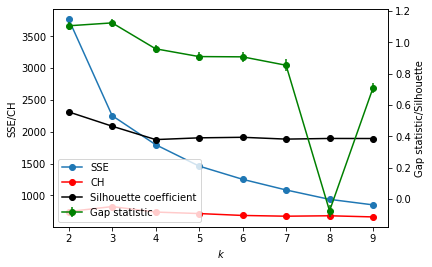

In [82]:
plot_internal(kmeans_all_gov['inertias'], kmeans_all_gov['chs'],
              kmeans_all_gov['scs'],  kmeans_all_gov['gss'],
              kmeans_all_gov['gssds'])

In [83]:
kmeans_gov = KMeans(n_clusters=4)
y_predict_gov3 = kmeans_gov.fit_predict(df_gov_re)

In [87]:
df_gov_c1['cluster'] = y_predict_gov3
df_gov_c1 = df_gov_c1.replace({'cluster': 0}, "Role Players")
df_gov_c1 = df_gov_c1.replace({'cluster': 1}, "Imports + Big Men")
df_gov_c1 = df_gov_c1.replace({'cluster': 3}, "Bench Warmers")
df_gov_c1 = df_gov_c1.replace({'cluster': 2}, "Starters")
df_gov_c10 = df_gov_c1.groupby('cluster').mean()
df_gov_c10[['PTS_avg', '3Pm_avg', 'REB_avg', 'APG_avg', 'BLK_avg', 'height',
            'MIN_avg']]

,PTS_avg,3Pm_avg,REB_avg,APG_avg,BLK_avg,height,MIN_avg
cluster,,,,,,,
Bench Warmers,1.871858,0.138230,1.453186,0.437965,0.128628,75.230088,7.481416
Imports + Big Men,25.114754,1.297377,13.209508,3.945246,1.286885,77.950820,38.892787
Role Players,5.925970,0.730547,2.702139,1.348607,0.223881,74.139303,17.135075
Starters,13.021217,1.375304,5.269652,3.110870,0.406261,74.808696,29.145217


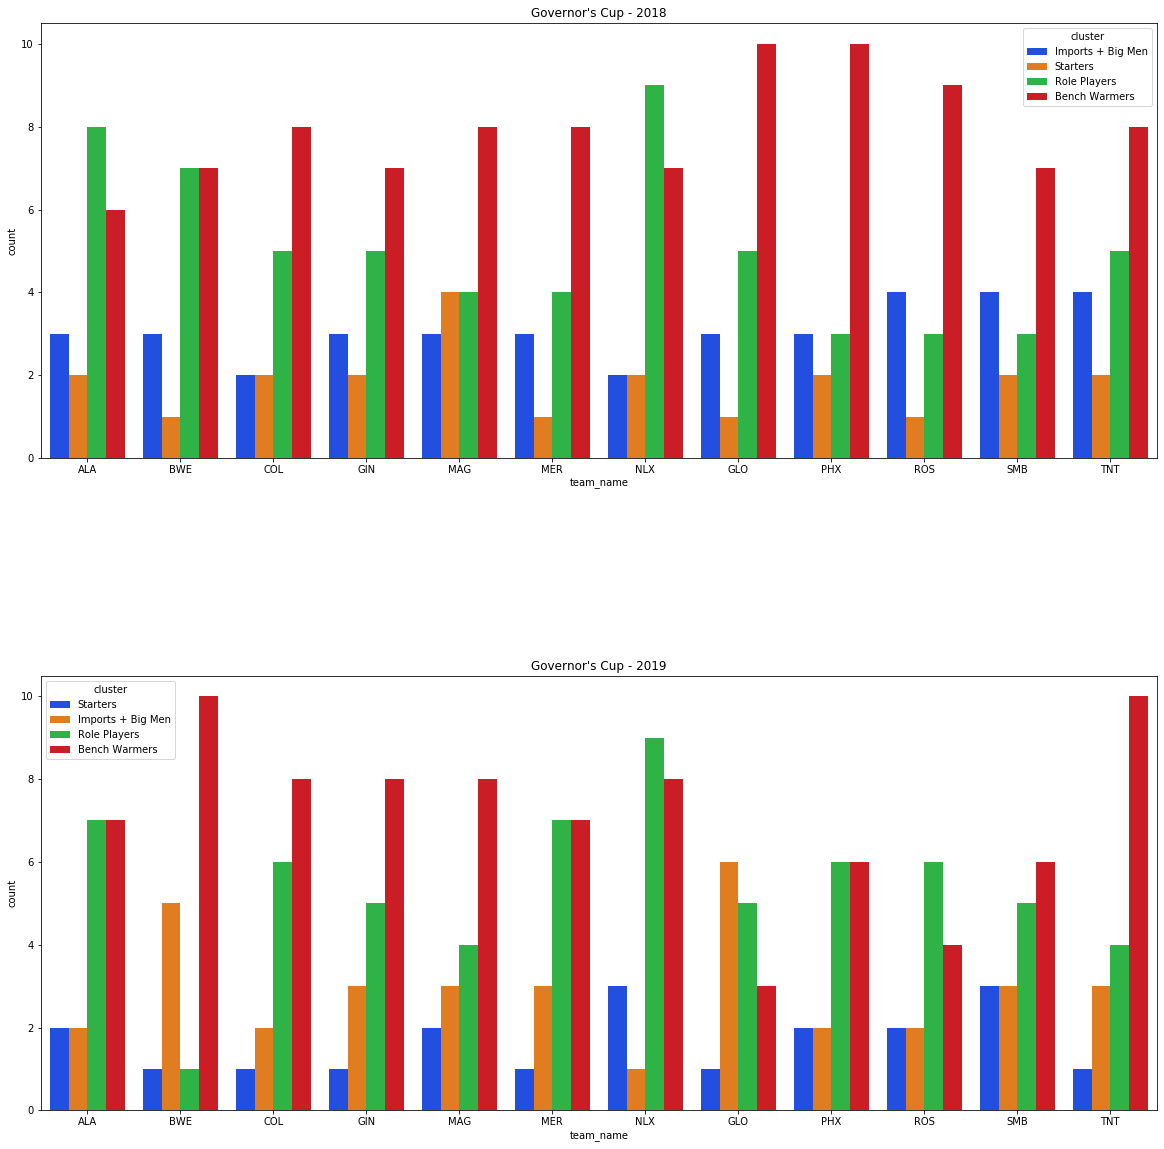

In [38]:
fig = plt.figure(figsize=(20,20))
gs2 = fig.add_gridspec(nrows=2, ncols=1, wspace=0.25, hspace=0.5)
years = ['2018','2019']
for x in range(2):
    ax = fig.add_subplot(gs2[x])
    sns.countplot(data=df_gov_c1[df_gov_c1['year'] == years[x]],
                  hue='cluster', x='team_name', palette='bright')
    ax.set_title("Governor's Cup - " + years[x])

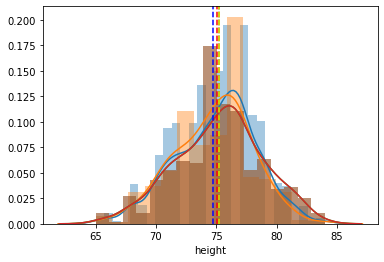

<Figure size 1440x720 with 0 Axes>

In [41]:
meanh = df_avgtot['height'].mean()
meanph = df_ph_c1['height'].mean()
meangov = df_gov_c1['height'].mean()
meancom = df_com_c1['height'].mean()

sns.distplot(df_avgtot['height'])
sns.distplot(df_ph_c1['height'])
sns.distplot(df_gov_c1['height'])
sns.distplot(df_com_c1['height'])

plt.axvline(meanh, color='r', linestyle='--')
plt.axvline(meanph, color='blue', linestyle='--')
plt.axvline(meangov, color='black', linestyle='--')
plt.axvline(meancom, color='yellow', linestyle='--')
plt.figure(figsize=(20,10));